### Mount google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


### Sizing system components:

#### Importing Libraries

In [ ]:
!pip install oemof



^C


  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
                                              0.0/92.3 kB ? eta -:--:--
     ---------------------------------------- 92.3/92.3 kB 5.5 MB/s eta 0:00:00
                                              0.0/60.1 kB ? eta -:--:--
     ---------------------------------------- 60.1/60.1 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
                                              0.0/156.6 kB ? eta -:--:--
     -------------------------------------- 156.6/156.6 kB 9.1 MB/s eta 0:00:00
                                              0.0/227.2 kB ? eta -:--:--
     ------------------------------------- 227.2/227.2 kB 13.6 MB/s eta 0:00:00
                                              0.0/74.8 kB ? eta -:--:--
     ---------------------------------------- 74.8/74.8 kB ? eta 0:00:00
                                         

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 2.2.2 which is incompatible.

[notice] A new release of pip is available: 23.1.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
!pip install oemof.thermal

  Using cached oemof_thermal-0.0.8-py3-none-any.whl.metadata (4.4 kB)
  Using cached oemof_solph-0.5.5-py3-none-any.whl.metadata (13 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.0 MB/s eta 0:00:00
Using cached oemof_thermal-0.0.8-py3-none-any.whl (22 kB)
Using cached oemof_solph-0.5.5-py3-none-any.whl (157 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 30.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.1
    Uninstalling numpy-2.2.1:
      Successfully uninstalled numpy-2.2.1
  Attempting uninstall: oemof.solph
    Found existing installation: oemof.solph 0.5.6
    Uninstalling oemof.solph-0.5.6:
      Successfully uninstalled oemof.solph-0.5.6


In [2]:

!pip install --upgrade --force-reinstall numpy scipy pandas

  Using cached numpy-2.2.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached scipy-1.15.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached pandas-2.2.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (89 kB)
  Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl.metadata (8.4 kB)
  Using cached pytz-2024.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2024.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached six-1.17.0-py2.py3-none-any.whl.metadata (1.7 kB)
Using cached numpy-2.2.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.4 MB)
Using cached scipy-1.15.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (40.6 MB)
Using cached pandas-2.2.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.1 MB)
Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl (229 kB)
Using cached pytz-2024.2-py2.py3-none-any.whl (508 kB)

In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()


✨🍰✨ Everything looks OK!


In [2]:
!conda install -c conda-forge coincbc -y


Channels:
 - conda-forge
Platform: linux-64
Solving environment: | / - \ | / done


==> WARNING: A newer version of conda exists. <==
    current version: 23.11.0
    latest version: 24.11.3

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.



# runall

In [4]:
import os
import oemof.thermal.compression_heatpumps_and_chillers as cmpr_hp_chiller
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from oemof import solph
from oemof.tools import economics
from oemof.solph import processing, views
from oemof.solph import EnergySystem, Flow, Model, constraints

#### 1) Importing data

#### 1.1 Reading input data: thermal and electric profiles

In [34]:
# Define the file path and date format
dataset_path = os.path.join('/content/drive/MyDrive/Colab Notebooks/okay/exam_project_profiles.csv')
date_format = '%Y-%m-%d %H:%M:%S'

# Use errors='coerce' to handle parsing errors
date_parser = lambda x: pd.to_datetime(x, format=date_format, errors='coerce')

# Read the CSV file
try:
    dataset = pd.read_csv(dataset_path, parse_dates=True, date_parser=date_parser)
except Exception as e:
    print(f"Error reading the file: {e}")
    dataset = pd.DataFrame()  # Create an empty DataFrame if the file can't be read

# Check if the 'timestamp' column exists
if 'timestamp' in dataset.columns:
    # Parse the existing 'timestamp' column
    dataset['timestamp'] = pd.to_datetime(dataset['timestamp'], format=date_format, errors='coerce')
else:
    # Create a new 'timestamp' column if it doesn't exist
    start_time = '2023-01-01 00:00:00'
    end_time = '2023-12-31 23:00:00'
    time_step = pd.to_timedelta('1 hour')
    dataset['timestamp'] = pd.date_range(start=start_time, end=end_time, freq=time_step)
    print("New 'timestamp' column created.")

# Set the 'timestamp' column as the index
dataset.set_index('timestamp', inplace=True)

# Drop NaN values in the DataFrame
dataset.dropna(inplace=True)

# Print the resulting DataFrame (optional)
print(dataset.head())


New 'timestamp' column created.
                     Unnamed: 0    Pel kW    Pth kW
timestamp                                          
2023-01-01 00:00:00           0  0.289583  0.398678
2023-01-01 01:00:00           1  0.285012  0.393958
2023-01-01 02:00:00           2  0.271620  0.383260
2023-01-01 03:00:00           3  0.278819  0.394840
2023-01-01 04:00:00           4  0.267483  0.388232


<ipython-input-34-2a5f4c0e5c2d>:13: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  input_profiles = pd.read_csv(profiles_file, parse_dates=True, date_parser=date_parser)


In [35]:
dataset

Unnamed: 0    Pel kW    Pth kW
timestamp                                          
2023-01-01 00:00:00           0  0.289583  0.398678
2023-01-01 01:00:00           1  0.285012  0.393958
2023-01-01 02:00:00           2  0.271620  0.383260
2023-01-01 03:00:00           3  0.278819  0.394840
2023-01-01 04:00:00           4  0.267483  0.388232
...                         ...       ...       ...
2023-12-31 19:00:00        8755  0.438614  0.373946
2023-12-31 20:00:00        8756  0.373206  0.388043
2023-12-31 21:00:00        8757  0.327886  0.367212
2023-12-31 22:00:00        8758  0.317922  0.351919
2023-12-31 23:00:00        8759  0.314448  0.358905

[8760 rows x 3 columns]

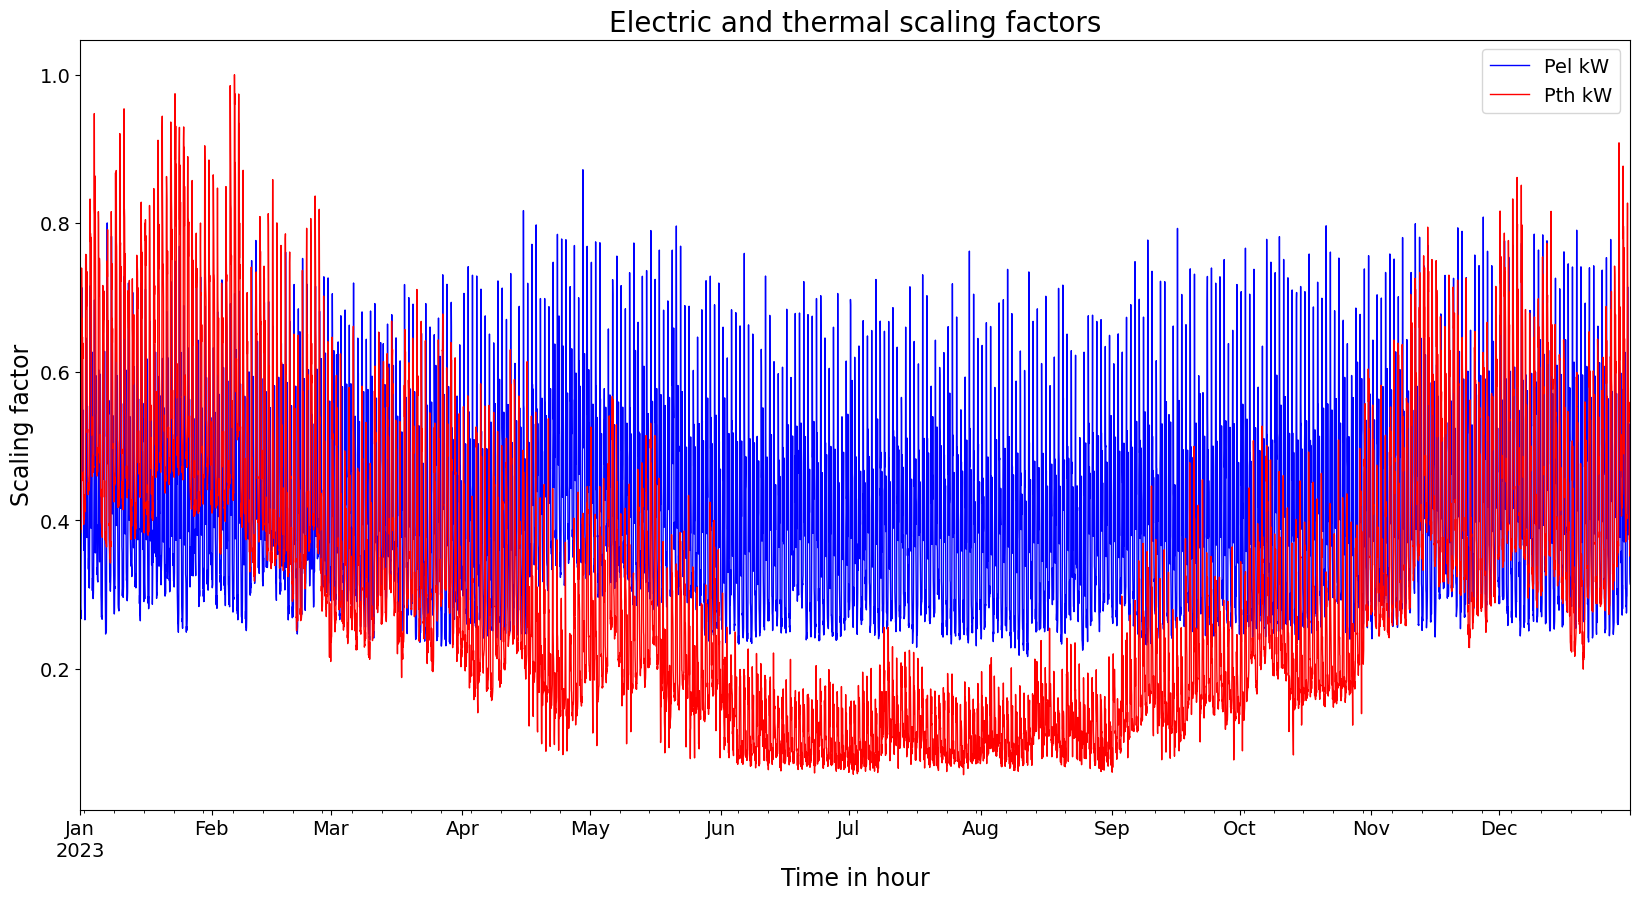

In [36]:
fig, ax = plt.subplots(figsize=(25,15))
dataset[['Pel kW', 'Pth kW']].plot(ax=ax, label=['Pel kW', 'Pth kW'], linewidth=1, color=['blue', 'red'])
ax.set_title('Electric and thermal scaling factors', fontsize=20)
ax.set_xlabel('Time in hour', fontsize=20)
ax.set_ylabel('Scaling factor', fontsize=20)
ax.legend(fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)

In [37]:
dataset[['Pth kW']].max()

Pth kW    1.0
dtype: float64

#### 1.2 Reading input data: solar PV generation and temperature

In [39]:
pv_dataset_path = os.path.join('/content/drive/MyDrive/Colab Notebooks/okay/Timeseries.csv')
date_format = '%Y-%m-%d %H:%M:%S'

# Use errors='coerce' to handle parsing errors
date_parserpvt = lambda x: pd.to_datetime(x, format=date_format, errors='coerce')

# Read only the 'P' and 'T2m' columns from the CSV file with the specified date_parser
columns_to_read = ['time', 'P', 'T2m']
pv_dataset = pd.read_csv(pv_dataset_path, parse_dates=True, date_parser=date_parserpvt, usecols=columns_to_read)

# If you want to create a new timestamp column:
start_timepvt = '2023-01-01 00:00:00'
end_timepvt = '2023-12-31 23:00:00'
time_steppvt = pd.to_timedelta('1 hour')
pv_dataset['time'] = pd.date_range(start=start_timepvt, end=end_timepvt, freq=time_steppvt)

# Set the newly created timestamp column as the index
pv_dataset.set_index('time', inplace=True)

# Drop NaN values in the DataFrame
pv_dataset.dropna(inplace=True)

<ipython-input-39-af37aeb6475d>:9: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  input_pvt = pd.read_csv(pv_temp_file, parse_dates=True, date_parser=date_parserpvt, usecols=columns_to_read)


In [40]:
pv_dataset

P   T2m
time                          
2023-01-01 00:00:00  0.0  7.65
2023-01-01 01:00:00  0.0  7.56
2023-01-01 02:00:00  0.0  7.42
2023-01-01 03:00:00  0.0  7.28
2023-01-01 04:00:00  0.0  7.19
...                  ...   ...
2023-12-31 19:00:00  0.0  4.18
2023-12-31 20:00:00  0.0  4.11
2023-12-31 21:00:00  0.0  3.79
2023-12-31 22:00:00  0.0  3.35
2023-12-31 23:00:00  0.0  2.94

[8760 rows x 2 columns]

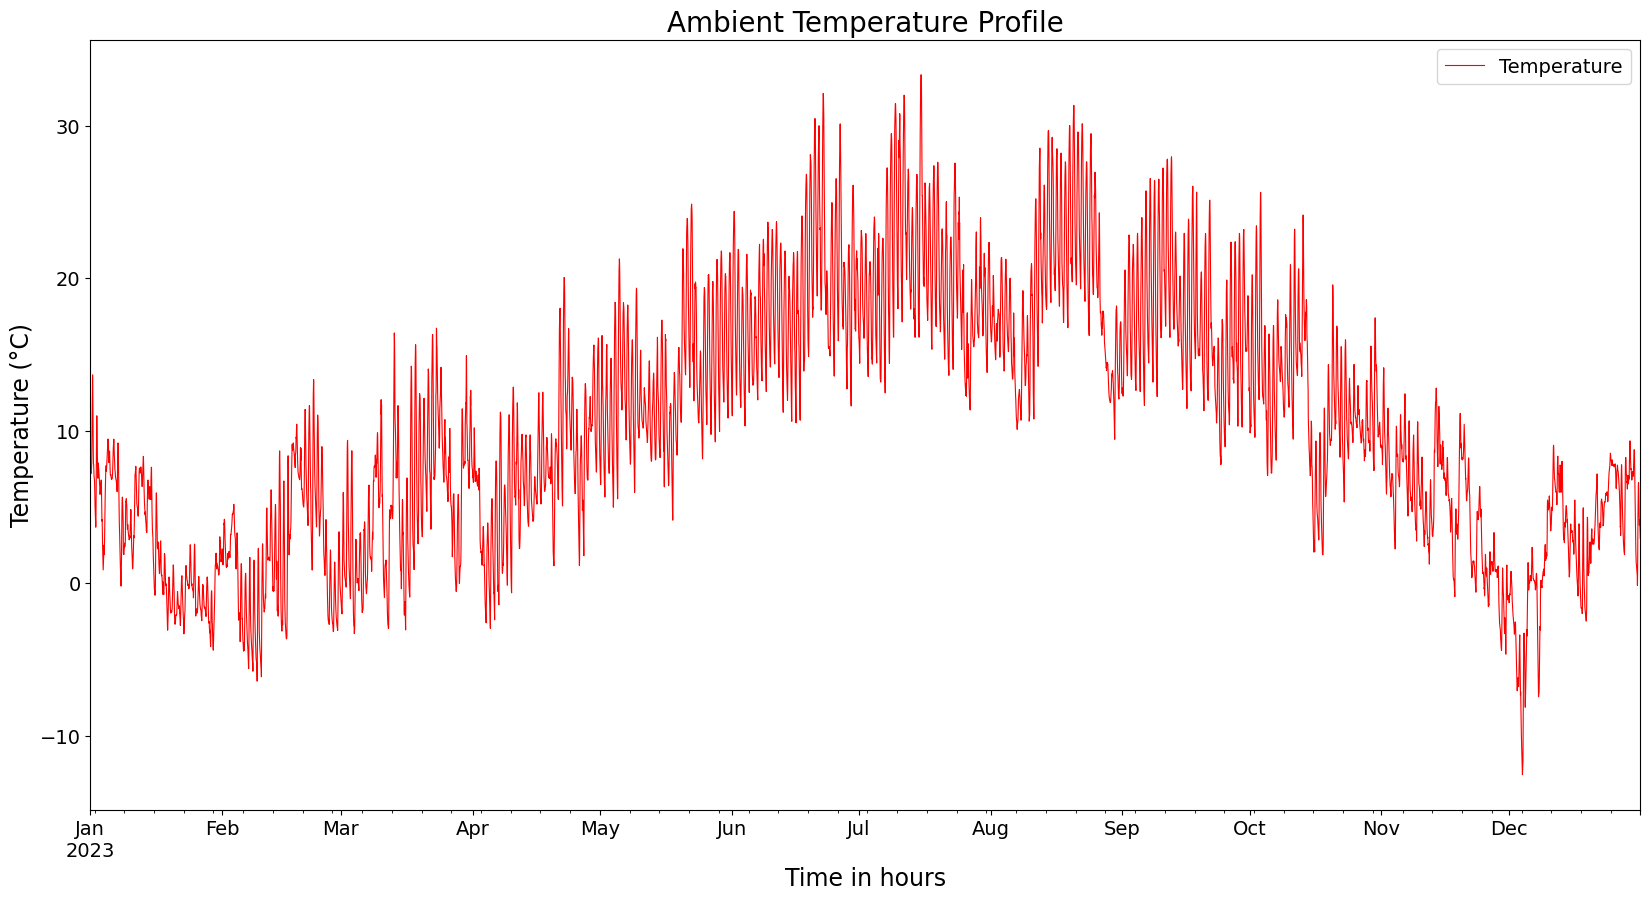

In [42]:
plt.figure(figsize=(25,15))
pv_dataset['T2m'].plot(label='Temperature', color='red', linewidth=0.8)
plt.title('Ambient Temperature Profile', fontsize=20)
plt.xlabel('Time in hours', fontsize=20)
plt.ylabel('Temperature (°C)', fontsize=20)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

### All features variable 

In [ ]:
## Boiler
pow_boiler = 200            # Thermal power output of boiler in kWth (Bosch Greenstar Gas Condensing Boiler: TF/TR = 80/60 °C)
eff_boiler = 0.98           # Efficiency of boiler (Bosch Greenstar Gas Condensing Boiler: TF/TR = 80/60 °C upto 98.7%)


In [ ]:
## Heat pump
pow_elhp = 390             # Electrical power input of heat pump in kW (Mitsubishi Electric Ecodan QAHV Heat Pump: Inlet/Outlet Temperature: TF/TR = 35 °C / 65 °C)
COP_hp = 4.6                # COP of the heat pump (Mitsubishi Electric Ecodan QAHV Heat Pump: 4.6)

In [ ]:
## Solar PV power plant
eff_solarpv = 1             # Efficiency solar PV system in kW

In [ ]:
## Storage devices
# Thermal storage
cap_th_store =  35245.098   # capacity of thermal storage in kWh

# electric storage
cap_elstore =     172       # Charging power battery in kW
discharge_power = 103       # Discharging power in kW
batt_store_cap =  800       # Battery capacity in kWh
batt_init_level = 0.5       # Initial state of charge of battery

In [ ]:
# Energy prices
#Gas
ng_price = 4                # Natural gas price in Ct/kWh
BCH4_price = 12             # Biomethane 12 price in Ct/kWh
#Electricity
el_lc_price = 25            # Large consumer electricity price including grid fees in Ct/kWh
el_pc_price = 35            # Private consumer electricity price including grid fees in Ct/kWh

In [ ]:
#CO2 Emissions
fCO2_el= 560                #CO2 Equivalent in g/kWh of Public Grid
fCO2_ngas= 240              #CO2 Equivalent in g/kWh of Natural Gas
fCO2_BioCH4= 140            #CO2 Equivalent in g/kWh of Biomethane
fpnren_el =1.8              #CO2 Equivalent Factor in g/kWh of Public Grid
fpnren_ngas=1.1             #CO2 Equivalent Factor in g/kWh of Natural Gas
fpnren_bioCH4=0.5           #CO2 Equivalent Factor in g/kWh of Biomethane

In [ ]:
# Revenues for selling electricity to the grid
rev_solarpv = -6           # Revenue from selling electricity to the grid from a solar PV system in Ct/kWh

In [43]:
# Investment cost
gboiler_cost = 84           # Gas boiler costs in €/kWth
hp_cost = 1440               # Heat pump (large) cost in  €/kWel
solarpv_cost = 750           # Solar power plant cost in  €/kWp 500kW
bos_cost = 0.3*solarpv_cost  # Solar power plant balance of system cost 30% of the total investment cost
th_store_cost= 1             # Investment costs Thermal Storage in €/l
el_storage_cost= 500         #Investment of Electrical battery storage in €/kwh

#### 2)   boundary conditions

#### 2.1  investment CAPEX

In [45]:
# specific investment for heat pump in €/kW based on electric power of the heat pump
epc_hp = economics.annuity(capex=hp_cost, n=15, wacc=0.05)
# specific investment for boiler in €/kW based on thermal power of the boiler
epc_boiler = economics.annuity(capex=gboiler_cost, n=15, wacc=0.05)
# specific investment for solar PV power plant in €/kWe based on thermal power of the boiler
epc_solarpv = economics.annuity(capex=solarpv_cost + bos_cost, n=15, wacc=0.05)
# specific investment for Thermal storage (Values can be changed according to the graph provided by prof-CAPEX IN €/kWh)
epc_th_storage = economics.annuity(capex=th_store_cost, n=15, wacc=0.05)



#### 3)  energy system model with buses and components

#### 3.1  the energy system and assigning time basis

In [46]:
es_inv = solph.EnergySystem(timeindex=dataset.index,
                         infer_last_interval=False)

In [47]:
es_inv

#### 3.2  buses

In [48]:
bus_mix = solph.Bus(label='bus_mix')            # mix of biomethane and natural gas bus
bus_pv = solph.Bus(label='bus_pv')              # solar pv energy generated bus
bus_el = solph.Bus(label='bus_el')              # electricity bus
bus_th = solph.Bus(label='bus_th')              # thermal bus
bus_gridfeed = solph.Bus(label='bus_gridfeed')  # Electricity from the solap PV power plant that can be sent to public grid of to bus el

#### 3.3  sources and sinks

In [49]:
## Sources

# Source natural gas supply from public natural gas pipeline
supply_ng = solph.components.Source(label='supply_ng',
                                   outputs={bus_mix: solph.Flow(variable_costs=ng_price/100,
                                                                 custom_attributes={"emission_factor":fCO2_ngas/1000})})


# Source electricity supply from public grid
supply_el = solph.components.Source(label='supply_el',
                                   outputs={bus_el: solph.Flow(variable_costs=el_lc_price/100,
                                                             custom_attributes={"emission_factor":fCO2_el/1000})})

# Source solar PV electricity
supply_elspv = solph.components.Source(label='supply_elspv',
                                   outputs={bus_pv: solph.Flow(fix=pv_dataset['P']/1000,
                                                               nominal_value=1)})

# Source biomethane supply
supply_bioch4 = solph.components.Source(label='supply_bioch4',
                                   outputs={bus_mix: solph.Flow(variable_costs=BCH4_price/100)})


In [50]:


## Sinks

# Sink heat load
demand_th = solph.components.Sink(label='demand_th',
                                 inputs={bus_th: solph.Flow(fix=dataset['Pth kW'],
                                                           nominal_value=550)})

# Sink electricity load
demand_el = solph.components.Sink(label='demand_el',
                                 inputs={bus_el: solph.Flow(fix=dataset['Pel kW'],
                                                           nominal_value=250)})

# Sink public electricity grid
pgrid_el = solph.components.Sink(label='pgrid_el',
                                 inputs={bus_gridfeed: solph.Flow(variable_costs=rev_solarpv/100)})

#### 4) Calculate COP for the heat pump

In [ ]:
temp_threshold_icing = 2
cops_ASHP = cmpr_hp_chiller.calc_cops(
    temp_high= [65],
    temp_low=pv_dataset['T2m'],
    quality_grade=0.4,
    mode='heat_pump',
    temp_threshold_icing=temp_threshold_icing,
    factor_icing=0.9)


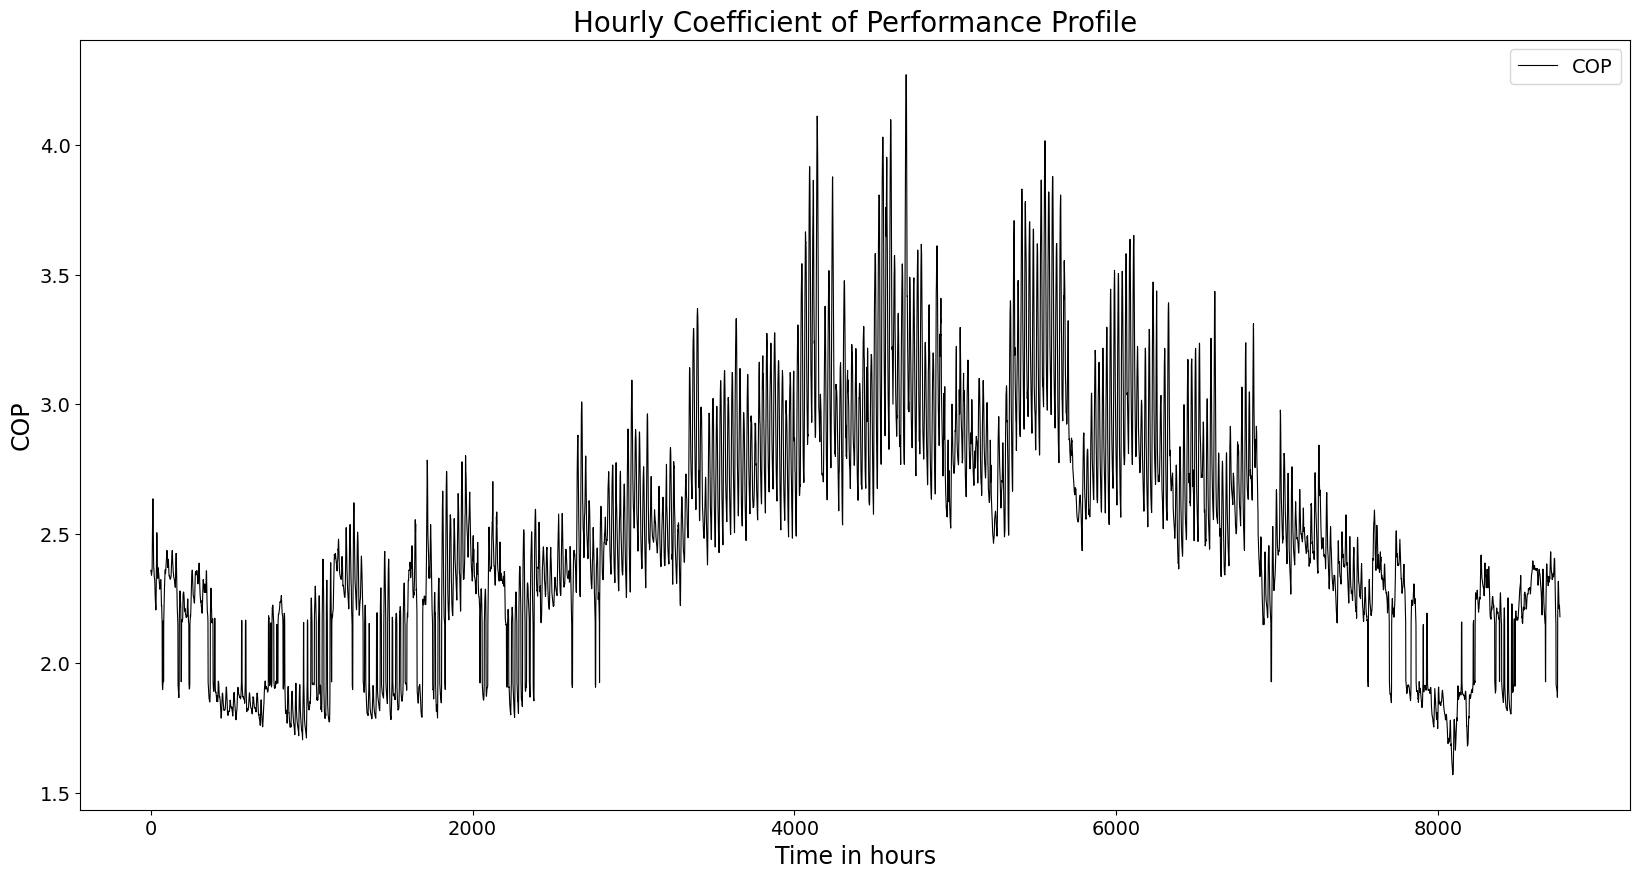

In [51]:

plt.figure(figsize=(20, 10))
plt.plot(cops_ASHP, label='COP', color='black', linewidth=0.8)
plt.title('Hourly Coefficient of Performance Profile', fontsize=20)
plt.xlabel('Time in hours', fontsize=20)
plt.ylabel('COP', fontsize=20)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

#### 5)  converters and storage

#### 5.1 Converters

In [52]:
# heat pump (hp)
heat_pump = solph.components.Converter(label='heat_pump',
                                      inputs={bus_el: solph.Flow(investment=solph.Investment(ep_costs=epc_hp,
                                                                                             minimum=1.0,
                                                                                             maximum=pow_elhp))},
                                      outputs={bus_th: solph.Flow()},
                                      conversion_factors={bus_th: cops_ASHP},
                                      )
# boiler
boiler = solph.components.Converter(label='boiler',
                                    inputs={bus_mix: solph.Flow()},
                                    outputs={bus_th: solph.Flow(investment=solph.Investment(ep_costs=epc_boiler,
                                                                                            minimum=1.0,
                                                                                            maximum=pow_boiler))},
                                    conversion_factors={bus_mix: 1/eff_boiler},
                                   )

# Solar PV power plant
solar_pv = solph.components.Converter(label='solar_pv',
                                      inputs={bus_pv: solph.Flow()},
                                      outputs={bus_gridfeed: solph.Flow()},
                                      conversion_factors={bus_pv: eff_solarpv})

# converter from bus_gridfeed to bus_el: allows solar Pv electricity to be splitted between grid feed and internal use for heat pump and electric demand
splitter = solph.components.Converter(label='splitter',
                                      inputs={bus_gridfeed: solph.Flow()},
                                      outputs={bus_el: solph.Flow()})

/usr/local/lib/python3.11/dist-packages/oemof/solph/flows/_flow.py:163: FutureWarning: For backward compatibility, the option investment overwrites the option nominal_value. Both options cannot be set at the same time.
  warn(msg, FutureWarning)


#### 5.2 Storages

In [53]:
# thermal storage
th_storage = solph.components.GenericStorage(label='th_storage',
                                             nominal_storage_capacity=None,
                                             inputs={bus_th: solph.Flow()},
                                             outputs={bus_th: solph.Flow()},
                                             investment=solph.Investment(ep_costs=epc_th_storage),
                                             initial_storage_level= None,
                                             balanced=True)

# Electric battery storage
el_storage = solph.components.GenericStorage(label='el_storage',
                                             nominal_storage_capacity=batt_store_cap,
                                             inputs={bus_el: solph.Flow(nominal_value=cap_elstore)},
                                             outputs={bus_el: solph.Flow(nominal_value=discharge_power)},
                                             initial_storage_level=batt_init_level,
                                             balanced=True)

/usr/local/lib/python3.11/dist-packages/oemof/solph/components/_generic_storage.py:213: FutureWarning: For backward compatibility, the option investment overwrites the option nominal_storage_capacity. Both options cannot be set at the same time.
  warn(msg, FutureWarning)


#### 6) Building energy system model

#### 6.1 Adding buses, sources, sinks and converters to the energy system

In [55]:
# Add buses to energy system
es_inv.add(bus_mix, bus_pv, bus_el, bus_th, bus_gridfeed)

# Add sources and sinks to energy system
es_inv.add(supply_ng, supply_elspv, supply_bioch4, supply_el, demand_th, demand_el, pgrid_el)

# Add converters and storages to energy system
es_inv.add(heat_pump, boiler, solar_pv, splitter, th_storage, el_storage)

In [56]:
es_inv

#### 6.2 Energy System Model

In [57]:
# Build energy system model
om = solph.Model(es_inv)

In [58]:
# define emission factors and CO2 limit
fCO2_el = 20 # unit g/kWh
fCO2_ngas = 240 # unit g/kWh
CO2_limit = 10000 # unit kg

'# define emission factors and CO2 limit\nfCO2_el = 20 # unit g/kWh\nfCO2_ngas = 240 # unit g/kWh\nCO2_limit = 10000 # unit kg'

In [31]:
# add the emission constraint
constraints.emission_limit(om, limit=CO2_limit)

#### 7) Solving MILP problem

In [59]:
# solve energy system model
om.solve(solver='cbc', solve_kwargs={'tee': True})

Welcome to the CBC MILP Solver 
Version: 2.10.12 
Build Date: Sep  3 2024 

command line - /usr/local/bin/cbc -printingOptions all -import /tmp/tmp7dqr2lvz.pyomo.lp -stat=1 -solve -solu /tmp/tmp7dqr2lvz.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 57642 (-73749) rows, 76673 (-89755) columns and 179531 (-170839) elements
Statistics for presolved model


Problem has 57642 rows, 76673 columns (26366 with objective) and 179531 elements
There are 13937 singletons with objective 
Column breakdown:
48888 of type 0.0->inf, 27783 of type 0.0->up, 0 of type lo->inf, 
2 of type lo->up, 0 of type free, 0 of type fixed, 
0 of type -inf->0.0, 0 of type -inf->up, 0 of type 0.0->1.0 
Row breakdown:
17512 of type E 0.0, 0 of type E 1.0, 0 of type E -1.0, 
13853 of type E other, 0 of type G 0.0, 0 of type G 1.0, 
0 of type G other, 26277 of type L 0.0, 0 of type L 1.0, 
0 of type L other, 0 of type Range 0.0->1.0, 0 of type Range other, 
0 of type Free 


{'Problem': [{'Name': 'unknown', 'Lower bound': 297494.169, 'Upper bound': 297494.169, 'Number of objectives': 1, 'Number of constraints': 131391, 'Number of variables': 166428, 'Number of nonzeros': 26366, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'User time': -1.0, 'System time': 23.23, 'Wallclock time': 23.9, 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Statistics': {'Branch and bound': {'Number of bounded subproblems': None, 'Number of created subproblems': None}, 'Black box': {'Number of iterations': 72069}}, 'Error rc': 0, 'Time': 23.940382480621338}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

#### 8) Analising results

#### 8.1 Optimal system component's sizes

In [60]:
# Buses result
results = solph.processing.results(om)
rbus_mix = solph.views.node(results,'bus_mix')['sequences']
rbus_pv = solph.views.node(results,'bus_pv')['sequences']
rbus_el = solph.views.node(results,'bus_el')['sequences']
rbus_th = solph.views.node(results,'bus_th')['sequences']
rbus_gridfeed= solph.views.node(results,'bus_gridfeed')['sequences']


In [61]:

#Thermal storage results
res_stor= (('th_storage', 'None'), 'storage_content')
res_stor_m = views.node(results,'th_storage')["sequences"][res_stor]

In [65]:
# Retriving results

# Total cost optimization
print('Total cost                                               {:.2f} €'.format(om.objective()))

# Retriving Power
pel_hp_res = results[(bus_el, heat_pump)]["scalars"]["invest"]
pth_boiler_res = results[(boiler, bus_th)]["scalars"]["invest"]
pth_store_res=views.node(results, 'th_storage')["scalars"]

# Printing retrived results
print(pth_store_res)
print('Optimum nominal electrical power input of heat pump:     {:.0f} kW'.format(pel_hp_res))
print('Optimum nominal thermal power output of boiler:          {:.0f} kW'.format(pth_boiler_res))


Total cost                                               297494.17 €
((th_storage, None), init_content)    130110.51
((th_storage, None), invest)          185834.61
((th_storage, None), total)           185834.61
Name: 2023-01-01 00:00:00, dtype: float64
Optimum nominal electrical power input of heat pump:     1 kW
Optimum nominal thermal power output of boiler:          200 kW


#### 8.2 Energy flows

In [67]:
# Natural Gas to bus_mix
supply_ng_to_bus_mix=  rbus_mix[(('supply_ng', 'bus_mix'), 'flow')].sum()
print ('Natural gas from network to bus_mix:                      {:.0f} kWh'.format(supply_ng_to_bus_mix))

## bus_mix to boiler unit
bus_mix_to_boiler=  rbus_mix[(('bus_mix', 'boiler'), 'flow')].sum()
print ('Fuel mix from bus_mix to boiler:                          {:.0f} kWh'.format(bus_mix_to_boiler))

print('\n')
# Biomethane to bus_mix
supply_bioch4_to_bus_mix=  rbus_mix[(('supply_bioch4', 'bus_mix'), 'flow')].sum()
print ('Biomethane from network to bus_mix:                       {:.0f} kWh'.format(supply_bioch4_to_bus_mix))

print('\n')
# supply_el to bus_el
supply_el_to_bus_el=  rbus_el[(('supply_el', 'bus_el'), 'flow')].sum()
print ('Electricity from public power grid to_bus_el:             {:.0f} kWh'.format(supply_el_to_bus_el))

# solar_pv to bus_gridfeed
solar_pv_to_bus_gridfeed=  rbus_gridfeed[(('solar_pv', 'bus_gridfeed'), 'flow')].sum()
print ('Electricity from solar pv power plant to bus_gridfeed:    {:.0f} kWh'.format(solar_pv_to_bus_gridfeed))

# bus_gridfeed to pgrid_el
bus_gridfeed_to_pgrid_el=  rbus_gridfeed[(('bus_gridfeed', 'pgrid_el'), 'flow')].sum()
print ('Electricity from solar pv power plant to the public grid: {:.0f} kWh'.format(bus_gridfeed_to_pgrid_el))

# bus_gridfeed to splitter
bus_gridfeed_to_splitter=  rbus_gridfeed[(('bus_gridfeed', 'splitter'), 'flow')].sum()
print ('Electricity from solar pv power plant to splitter:        {:.0f} kWh'.format(bus_gridfeed_to_splitter))

print('\n')
# boiler to bus_th
boiler_to_bus_th=  rbus_th[(('boiler', 'bus_th'), 'flow')].sum()
print ('Heat from boiler to bus_th:                               {:.0f} kWh'.format(boiler_to_bus_th))

# heat_pump unit to bus_th
heat_pump_to_bus_th=  rbus_th[(('heat_pump', 'bus_th'), 'flow')].sum()
print ('Heat from heat pump to bus_th:                            {:.0f} kWh'.format(heat_pump_to_bus_th))

# bus_th to th_storage
bus_th_to_th_storage=  rbus_th[(('bus_th', 'th_storage'), 'flow')].sum()
print ('Heat from bus_th to th_storage:                           {:.0f} kWh'.format(bus_th_to_th_storage))

# th_storage to bus_th
th_storage_to_bus_th=  rbus_th[(('th_storage', 'bus_th'), 'flow')].sum()
print ('Heat from th_storage to bus_th:                           {:.0f} kWh'.format(th_storage_to_bus_th))

print('\n')
# bus_th to demand_th
bus_th_to_demand_th=  rbus_th[(('bus_th', 'demand_th'), 'flow')].sum()
print ('Heat from bus_th to demand_th:                            {:.0f} kWh'.format(bus_th_to_demand_th))

# Solar PV power plant to bus_el
splitter_to_bus_el=  rbus_el[(('splitter', 'bus_el'), 'flow')].sum()
print ('Electricity from solar PV power plant to bus_el:          {:.0f} kWh'.format(splitter_to_bus_el))

# bus_el to el_storage
bus_el_to_el_storage=  rbus_el[(('bus_el', 'el_storage'), 'flow')].sum()
print ('Electricity from bus_el to el_storage:                    {:.0f} kWh'.format(bus_el_to_el_storage))

# el_storage to bus_el
el_storage_to_bus_el=  rbus_el[(('el_storage', 'bus_el'), 'flow')].sum()
print ('Electricity from el_storage to bus_el:                    {:.0f} kWh'.format(el_storage_to_bus_el))

print('\n')
# bus_el to heat_pump
bus_el_to_heat_pump=  rbus_el[(('bus_el', 'heat_pump'), 'flow')].sum()
print ('Electricity from bus_el heat_pump:                        {:.0f} kWh'.format(bus_el_to_heat_pump))

# bus_el to demand_el
bus_el_to_demand_el=  rbus_el[(('bus_el', 'demand_el'), 'flow')].sum()
print ('Electricity from bus_el to demand_el:                     {:.0f} kWh'.format(bus_el_to_demand_el))


Natural gas from network to bus_mix:                      1453245 kWh
Fuel mix from bus_mix to boiler:                          1453245 kWh


Biomethane from network to bus_mix:                       0 kWh


Electricity from public power grid to_bus_el:             878813 kWh
Electricity from solar pv power plant to bus_gridfeed:    581 kWh
Electricity from solar pv power plant to the public grid: 0 kWh
Electricity from solar pv power plant to splitter:        581 kWh


Heat from boiler to bus_th:                               1424180 kWh
Heat from heat pump to bus_th:                            5101 kWh
Heat from bus_th to th_storage:                           245318 kWh
Heat from th_storage to bus_th:                           245318 kWh


Heat from bus_th to demand_th:                            1429281 kWh
Electricity from solar PV power plant to bus_el:          581 kWh
Electricity from bus_el to el_storage:                    494 kWh
Electricity from el_storage to bus_el:        

#### 9) Printing results

#### 9.1 Natural gas and biomethane flow to bus_mix and bus_mix to boiler flows

In [68]:
plt.figure(figsize=(25,15))
profiles = solph.processing.results(om)
rbus_mix = solph.views.node(profiles,'bus_mix')['sequences']
rbus_mix

((bus_mix, boiler), flow)  \
timestamp                                        
2023-01-01 00:00:00                  204.08163   
2023-01-01 01:00:00                  204.08163   
2023-01-01 02:00:00                  204.08163   
2023-01-01 03:00:00                  204.08163   
2023-01-01 04:00:00                  204.08163   
...                                        ...   
2023-12-31 19:00:00                  204.08163   
2023-12-31 20:00:00                  204.08163   
2023-12-31 21:00:00                  204.08163   
2023-12-31 22:00:00                  204.08163   
2023-12-31 23:00:00                        NaN   

                     ((supply_bioch4, bus_mix), flow)  \
timestamp                                               
2023-01-01 00:00:00                               0.0   
2023-01-01 01:00:00                               0.0   
2023-01-01 02:00:00                               0.0   
2023-01-01 03:00:00                               0.0   
2023-01-01 04:00:00                               0.0   
...                                               ...   
2023-12-31 19:00:00                               0.0   
2023-12-31 20:00:00                               0.0   
2023-12-31 21:00:00                               0.0   
2023-12-31 22:00:00                               0.0   
2023-12-31 23:00:00                               NaN   

                     ((supply_ng, bus_mix), flow)  
timestamp                                          
2023-01-01 00:00:00                     204.08163  
2023-01-01 01:00:00                     204.08163  
2023-01-01 02:00:00                     204.08163  
2023-01-01 03:00:00                     204.08163  
2023-01-01 04:00:00                     204.08163  
...                                           ...  
2023-12-31 19:00:00                     204.08163  
2023-12-31 20:00:00                     204.08163  
2023-12-31 21:00:00                     204.08163  
2023-12-31 22:00:00                     204.08163  
2023-12-31 23:00:00                           NaN  

[8760 rows x 3 columns]

<Figure size 2000x1000 with 0 Axes>

#### 9.2 Boiler input and output

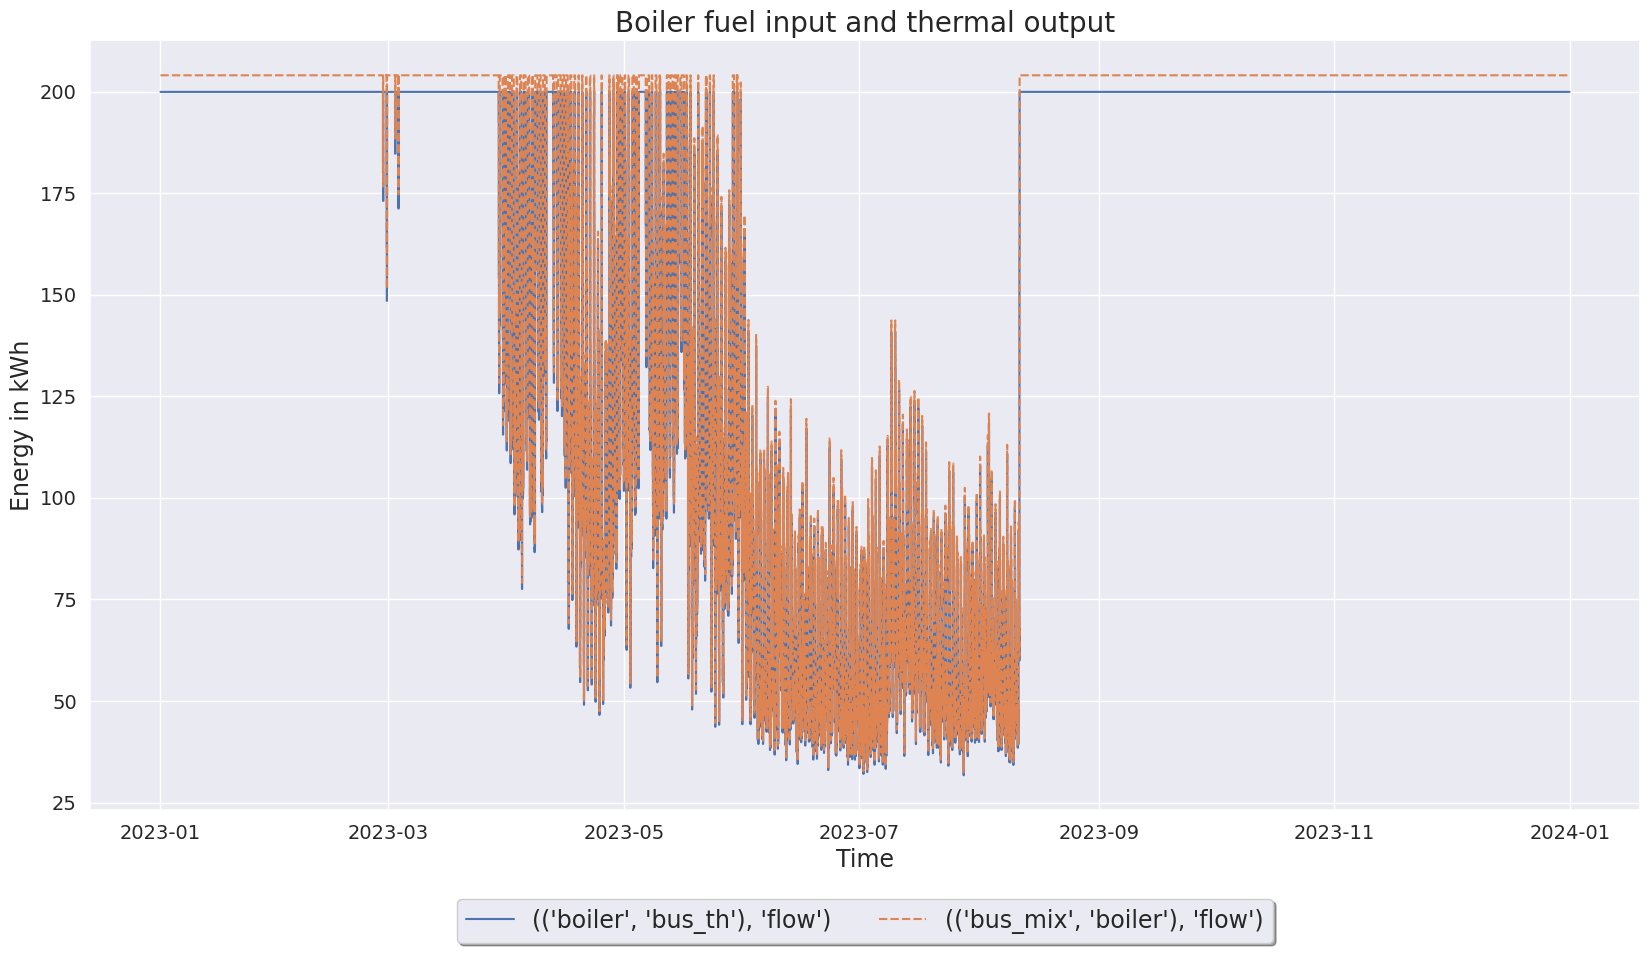

In [69]:
# Read results
plt.figure(figsize=(25,15))
profiles = solph.processing.results(om)
rboiler = solph.views.node(profiles,'boiler')['sequences']

sns.set(style='darkgrid')
plot = sns.lineplot(data=rboiler, drawstyle='steps-post')
plt.title('Boiler fuel input and thermal output', fontsize=20)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Energy in kWh', fontsize=20)
plot.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), shadow=True, ncol=2, fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

#### 9.4 Heat Pump input and output

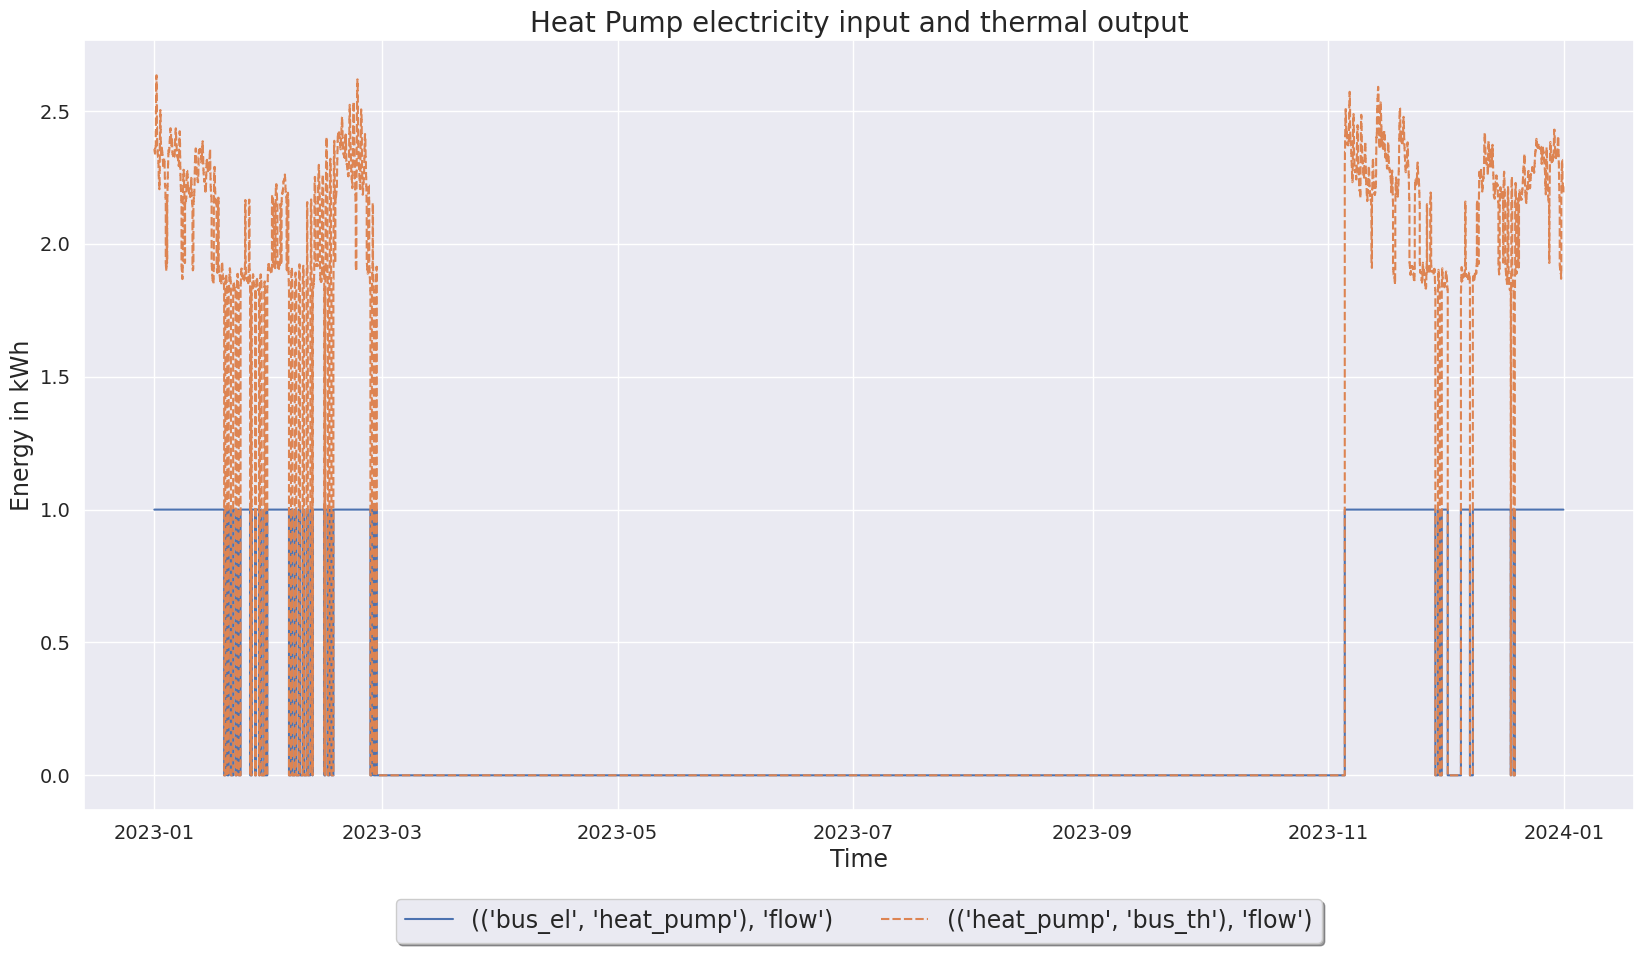

In [70]:
# Read results
plt.figure(figsize=(25,15))
profiles = solph.processing.results(om)
rheat_pump= solph.views.node(profiles,'heat_pump')['sequences']

sns.set(style='darkgrid')
plot = sns.lineplot(data=rheat_pump, drawstyle='steps-post')
plt.title('Heat Pump electricity input and thermal output', fontsize=20)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Energy in kWh', fontsize=20)
plot.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), shadow=True, ncol=2, fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

#### 9.5 Solar PV power plant

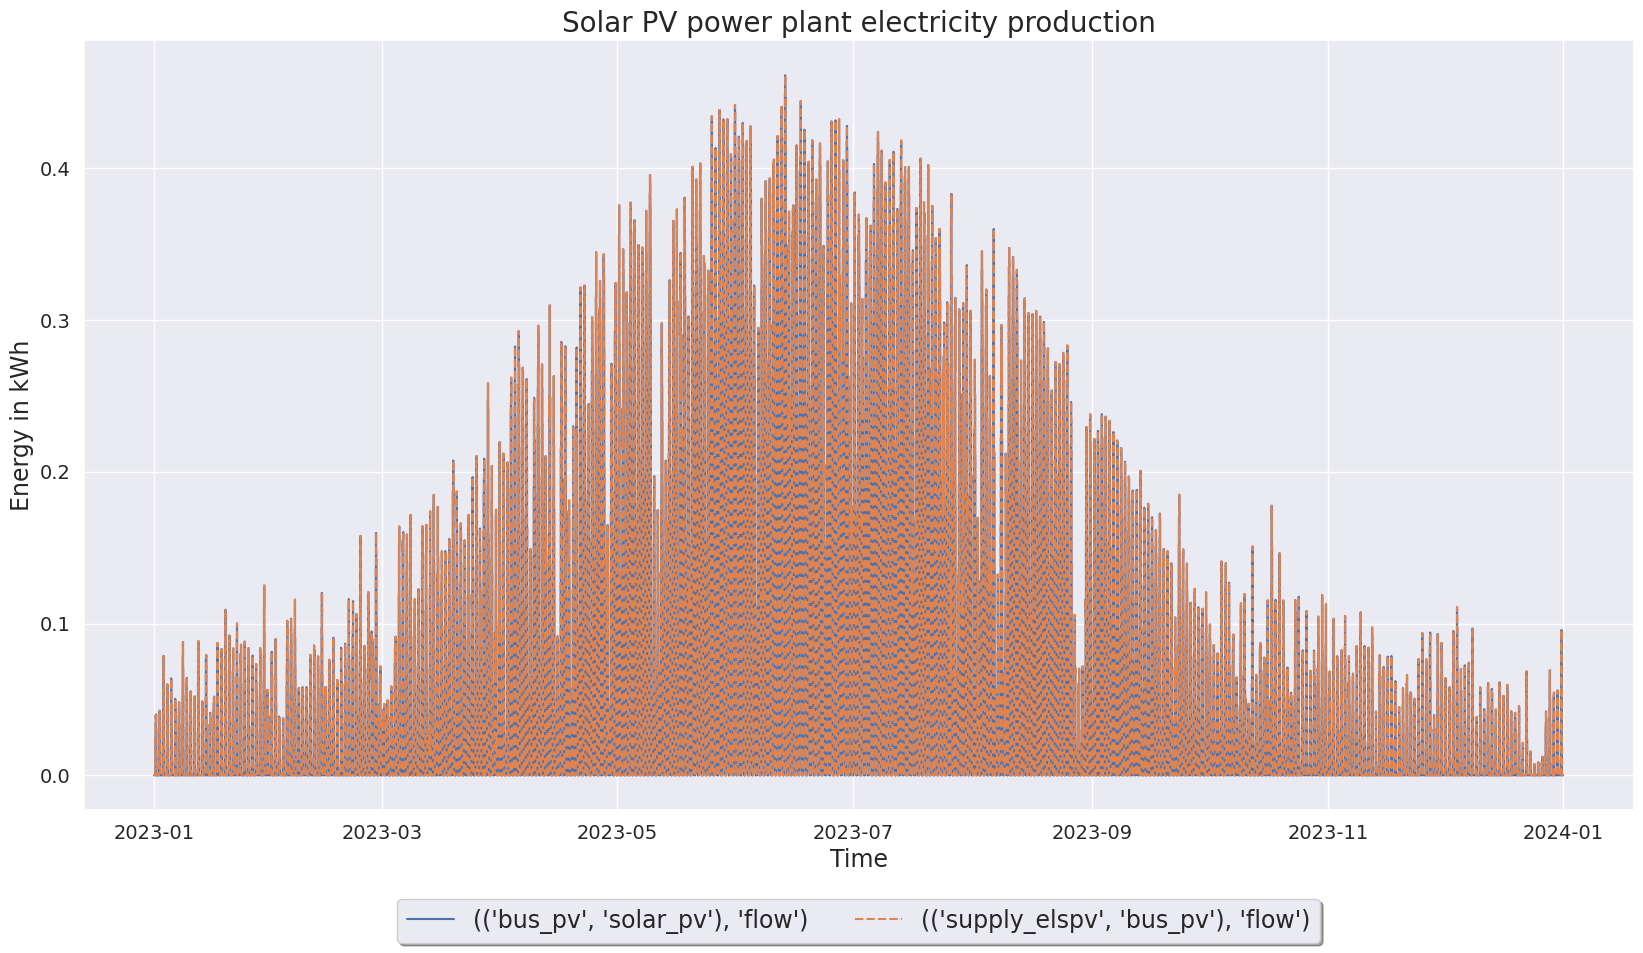

In [71]:
# Read results
plt.figure(figsize=(25,15))
profiles = solph.processing.results(om)
rbus_pv = solph.views.node(profiles,'bus_pv')['sequences']

sns.set(style='darkgrid')
plot = sns.lineplot(data=rbus_pv, drawstyle='steps-post')
plt.title('Solar PV power plant electricity production', fontsize=20)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Energy in kWh', fontsize=20)
plot.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), shadow=True, ncol=2, fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

#### 9.6 Thermal bus

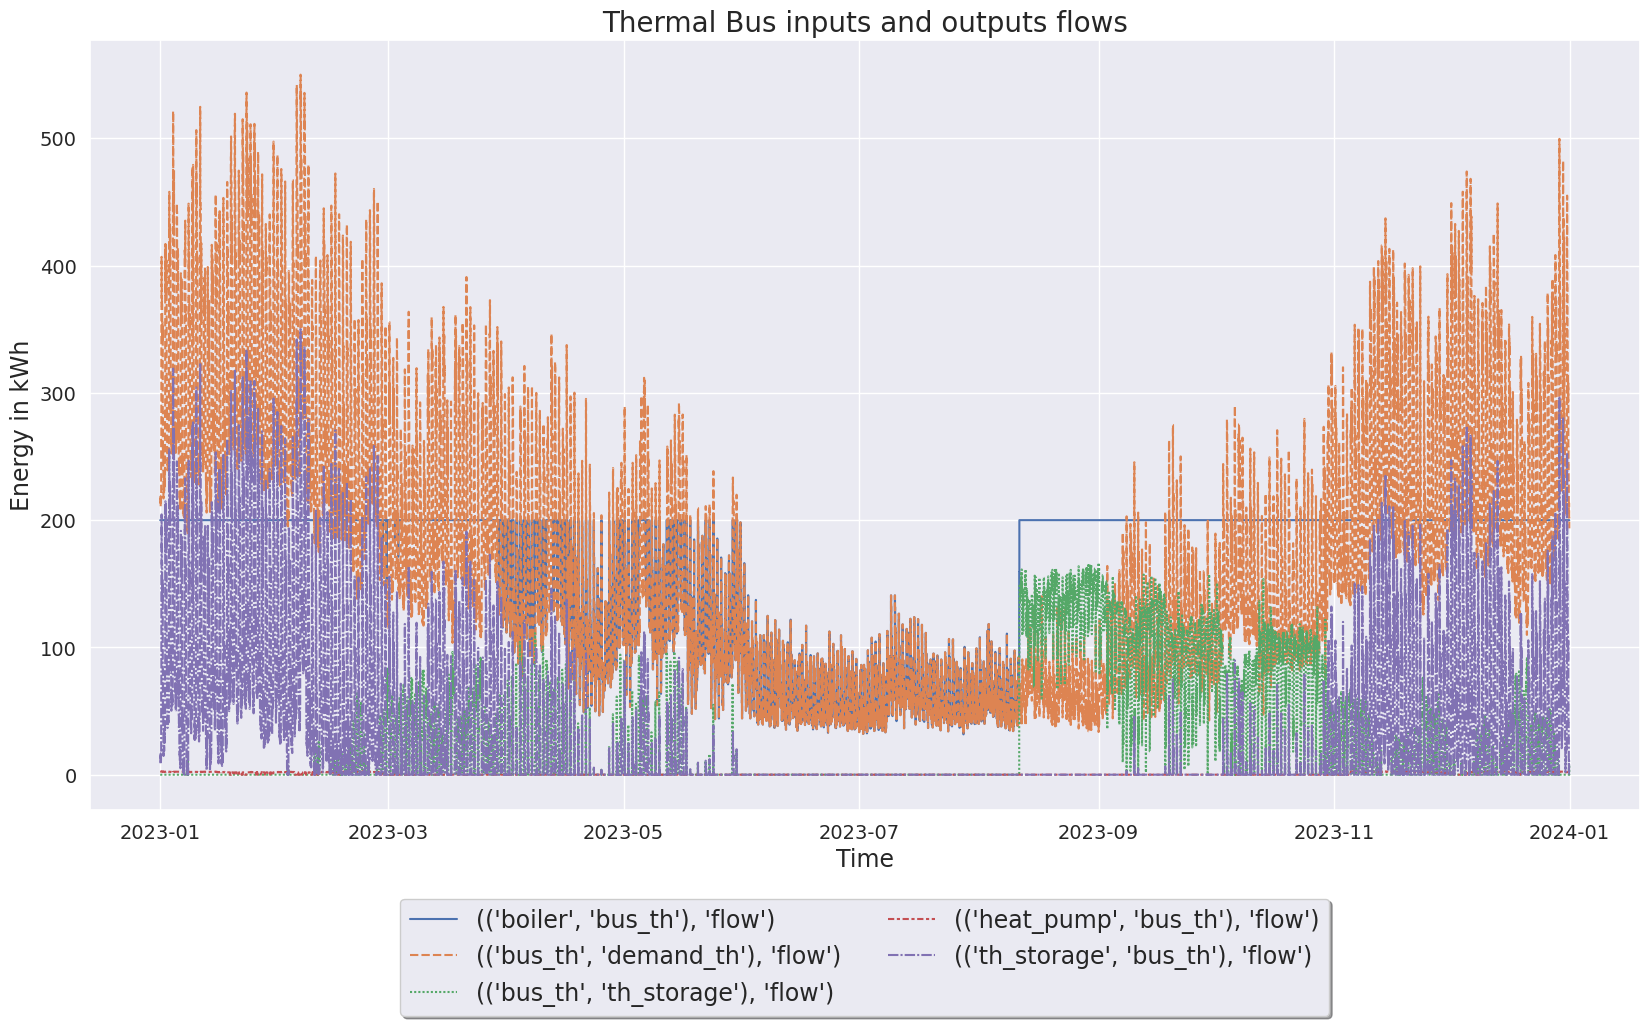

In [72]:
# Read results
plt.figure(figsize=(25,15))
profiles = solph.processing.results(om)
rbus_th = solph.views.node(profiles,'bus_th')['sequences']

sns.set(style='darkgrid')
plot = sns.lineplot(data=rbus_th, drawstyle='steps-post')
plt.title('Thermal Bus inputs and outputs flows', fontsize=20)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Energy in kWh', fontsize=20)
plot.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), shadow=True, ncol=2, fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

#### 9.5 Electric bus

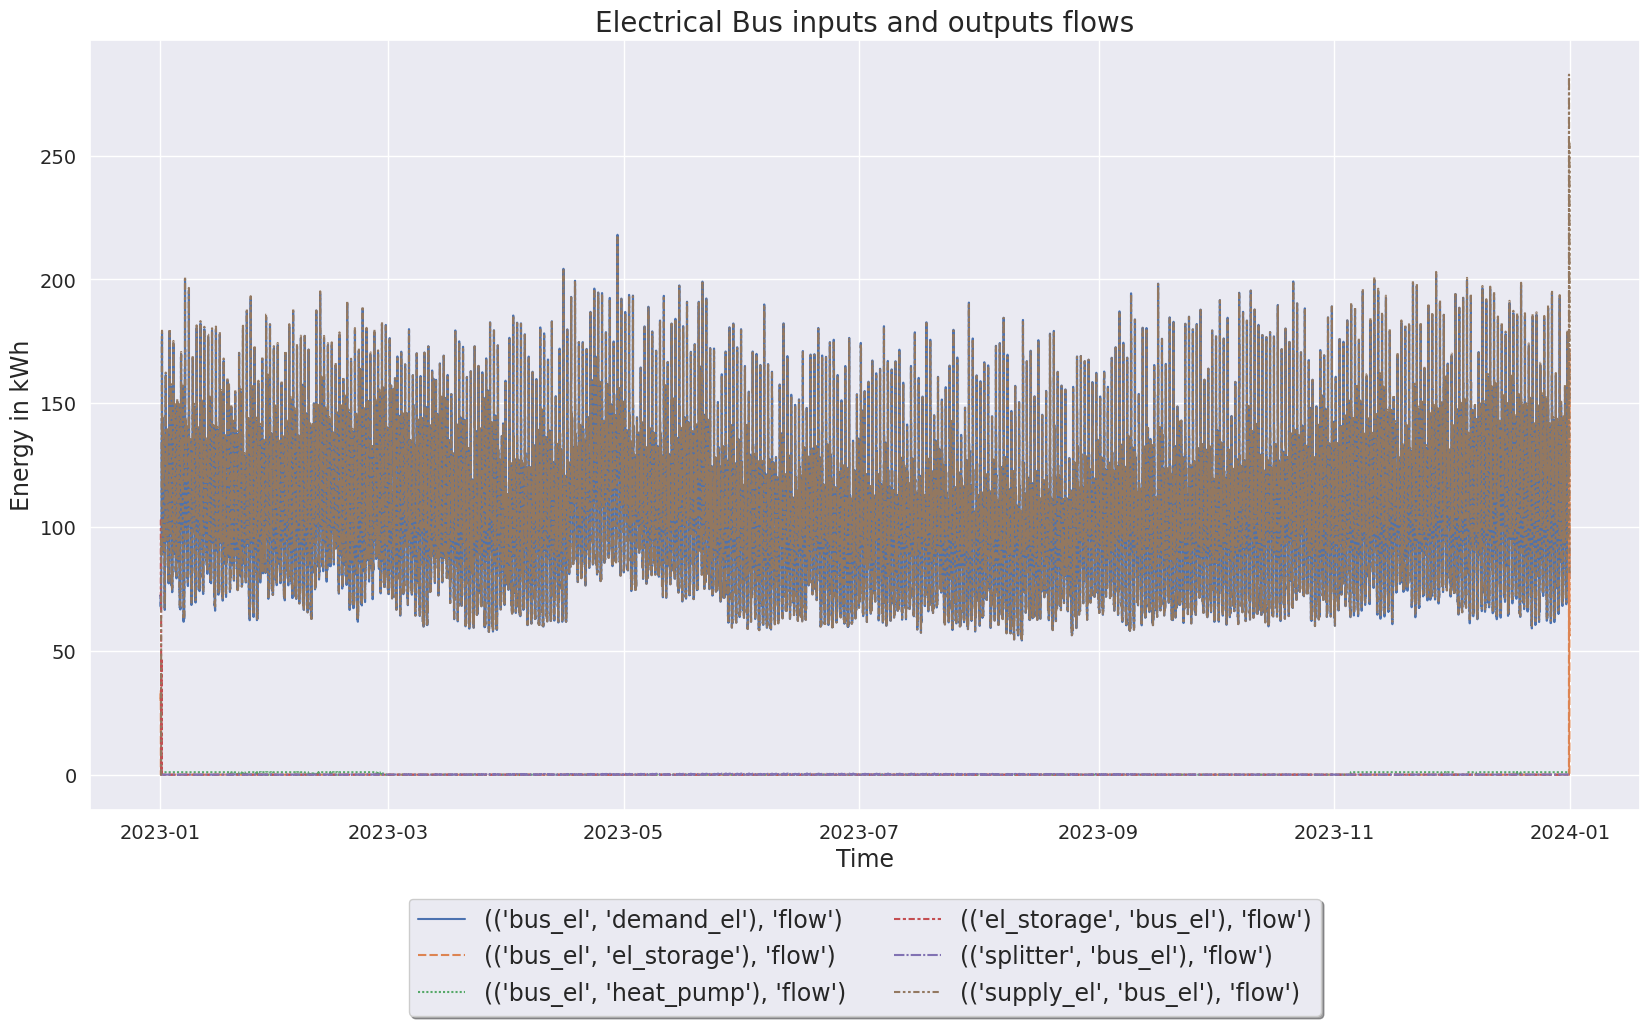

In [73]:
# Read results
plt.figure(figsize=(25,15))
profiles = solph.processing.results(om)
rbus_el = solph.views.node(profiles,'bus_el')['sequences']

sns.set(style='darkgrid')
plot = sns.lineplot(data=rbus_el, drawstyle='steps-post')
plt.title('Electrical Bus inputs and outputs flows', fontsize=20)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Energy in kWh', fontsize=20)
plot.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), shadow=True, ncol=2, fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

#### 9.6 Electric storage

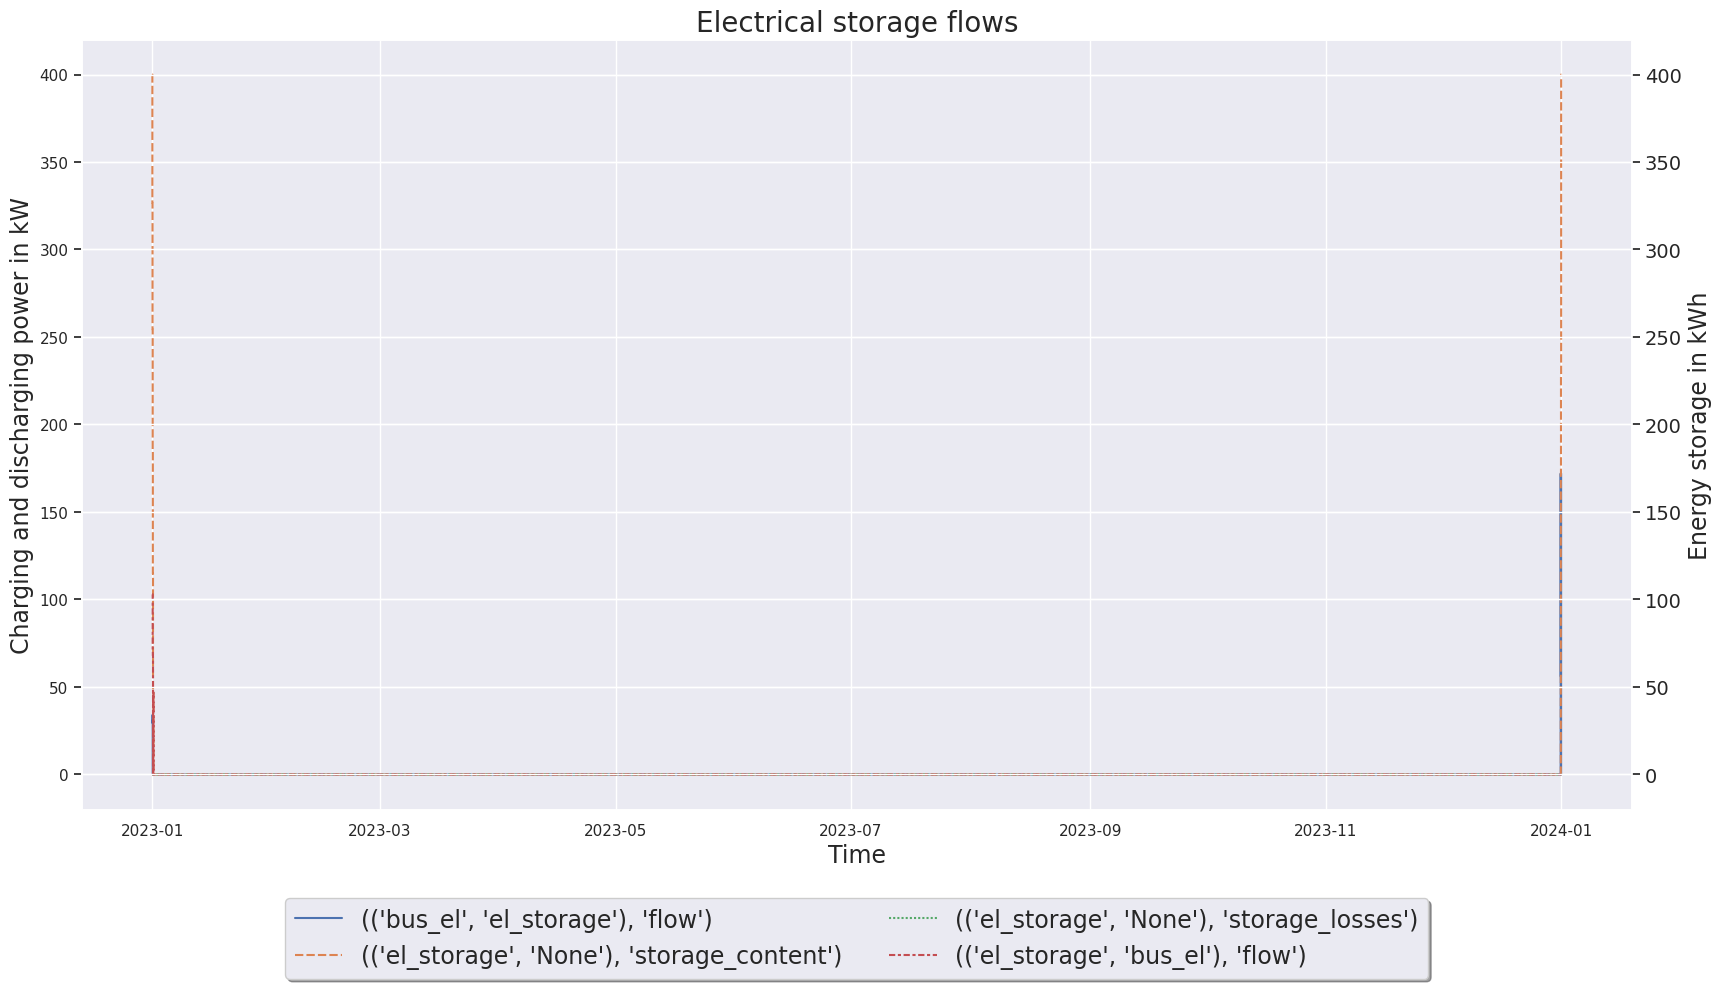

In [74]:
plt.figure(figsize=(20, 10))
profiles = solph.processing.results(om)
rel_storage = solph.views.node(profiles, 'el_storage')['sequences']

sns.set(style='darkgrid')
ax1 = sns.lineplot(data=rel_storage, drawstyle='steps-post')
plt.title('Electrical storage flows', fontsize=20)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Charging and discharging power in kW', fontsize=20)

# Create a twin axis for the right y-axis
ax2 = ax1.twinx()
ax2.set_ylabel('Energy storage in kWh', fontsize=20)

# Set the limits for the right y-axis to match the left y-axis
ax2.set_ylim(ax1.get_ylim())

# Add legend
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), shadow=True, ncol=2, fontsize=20)

# Set tick font sizes
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

#### 9.6 Thermal storage

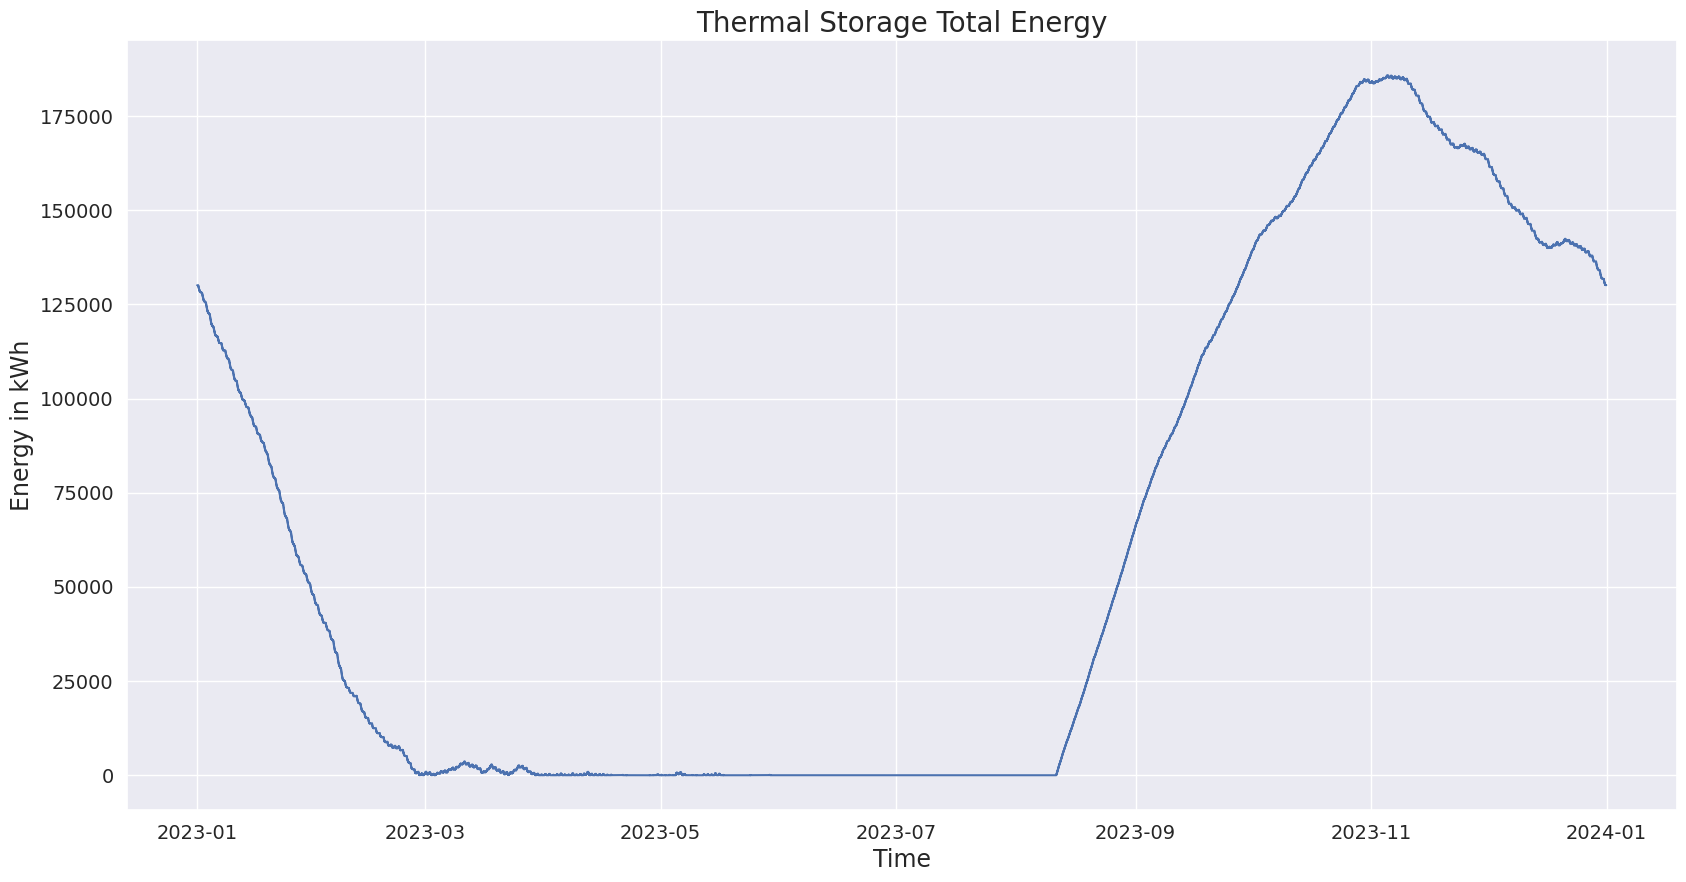

In [75]:
plt.figure(figsize=(25,15))
sns.set(style='darkgrid')
plot = sns.lineplot(data=res_stor_m, drawstyle='steps-post')
plt.title('Thermal Storage Total Energy', fontsize=20)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Energy in kWh', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

#### 9.6.1 Thermal Storage charging Discharging

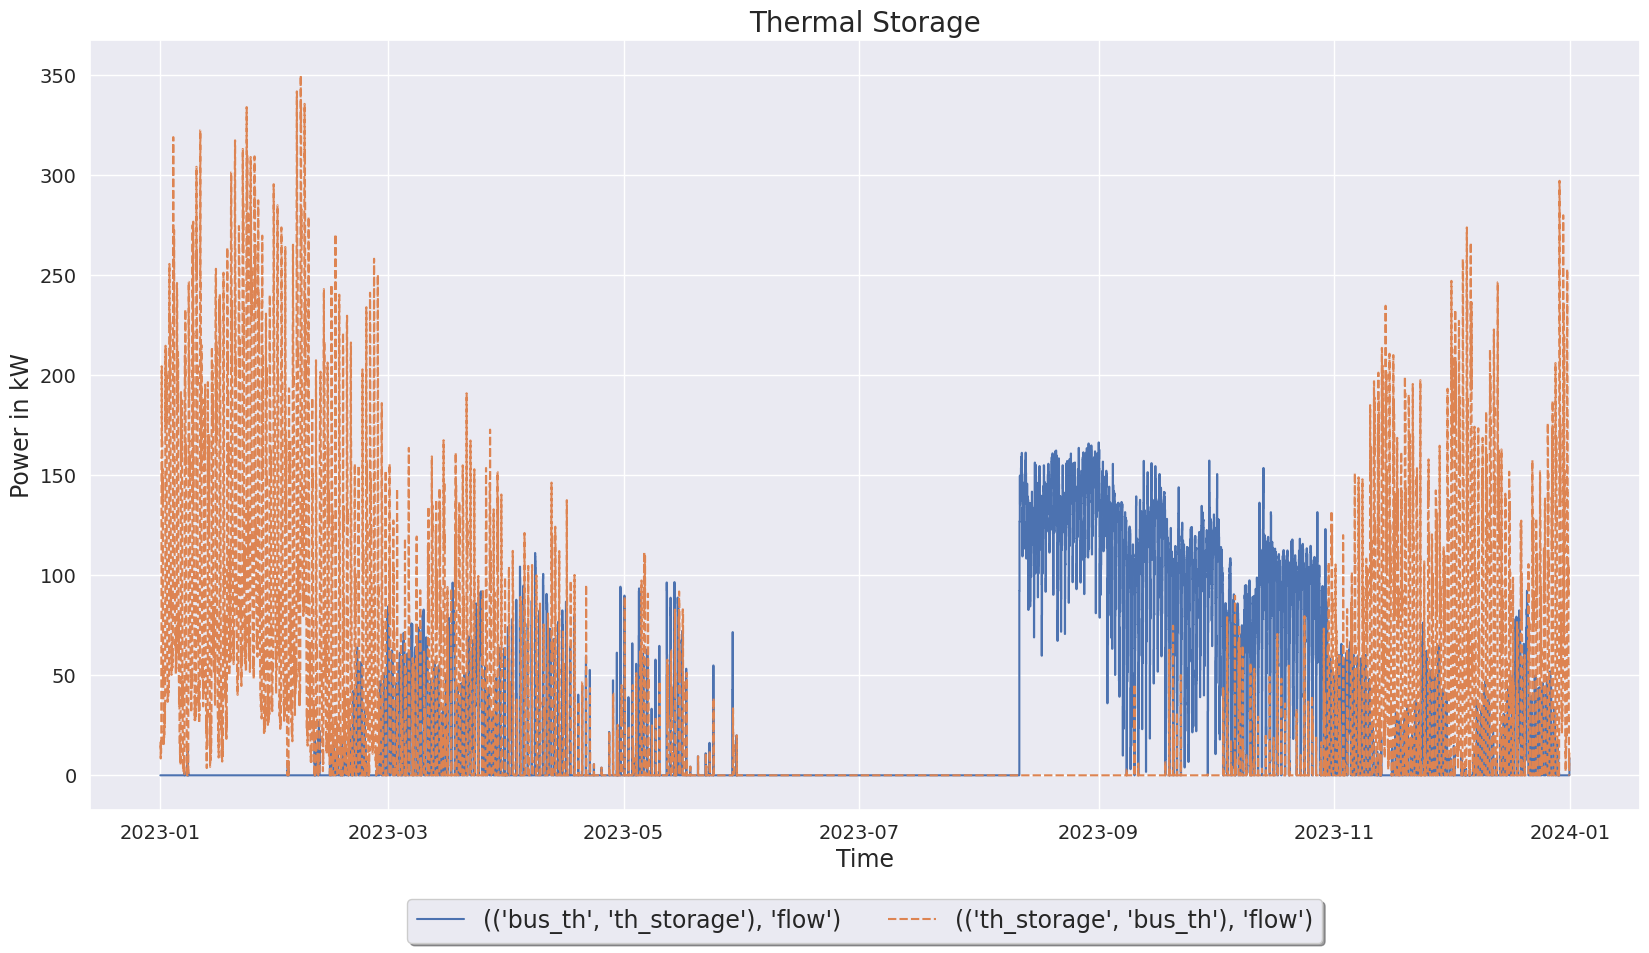

In [76]:
plt.figure(figsize=(25,15))
sns.set(style='darkgrid')
profiles = solph.processing.results(om)
rbus_th = solph.views.node(profiles, 'th_storage')['sequences']

# Check if the flow exists before attempting to drop it
flow_to_drop = (('th_storage', 'None'),'storage_content')
if flow_to_drop in rbus_th.columns:
    rbus_th_filtered = rbus_th.drop(flow_to_drop, axis=1)
else:
    rbus_th_filtered = rbus_th.copy()

plot = sns.lineplot(data=rbus_th_filtered, drawstyle='steps-post')
plt.title('Thermal Storage', fontsize=20)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Power in kW', fontsize=20)
plot.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), shadow=True, ncol=2, fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

#### 10. CAPEX


In [77]:
#CAPEX of Heat Pump
CAPEX_heat_pump = pow_elhp*hp_cost
print('CAPEX of the Heat Pump:                 {:.0f}  €'.format(CAPEX_heat_pump))

#CAPEX of Boiler
CAPEX_boiler = pow_boiler*gboiler_cost
print('CAPEX of the Boiler:                     {:.0f}  €'.format(CAPEX_boiler))

#CAPEX of Solar PV power plant
CAPEX_solar_pv =(solarpv_cost+bos_cost)
print('CAPEX of the Solar PV power plant:      {:.0f}  €'.format(CAPEX_solar_pv))

#CAPEX of Thermal Storage
CAPEX_th_storage = th_store_cost*cap_th_store
print('CAPEX of the Thermal Storage:           {:.0f}  €'.format(CAPEX_th_storage))

#CAPEX of the Electrical Storage
CAPEX_el_storage = el_storage_cost*batt_store_cap
print('CAPEX of the Electrical Storage:        {:.0f}  €'.format(CAPEX_el_storage))

print('\n')
#TotalCAPEX
Total_CAPEX = CAPEX_heat_pump  + CAPEX_boiler + CAPEX_solar_pv + CAPEX_th_storage + CAPEX_el_storage
print('Total CAPEX of the Energy System:       {:.0f}  €'.format(Total_CAPEX))


CAPEX of the Heat Pump:                 561600  €
CAPEX of the Boiler:                     16800  €
CAPEX of the Solar PV power plant:      975  €
CAPEX of the Thermal Storage:           35245  €
CAPEX of the Electrical Storage:        400000  €


Total CAPEX of the Energy System:       1014620  €


#### 10.1 CAPEX Thermal

In [80]:
#CAPEX of Heat Pump
print('CAPEX of the Heat Pump:                                           {:.0f}  €'.format(CAPEX_heat_pump))

pro_supply_el_to_heat_pump = bus_el_to_heat_pump/(bus_el_to_heat_pump+bus_el_to_demand_el)

#CAPEX of Boiler
print('CAPEX of the Boiler:                                              {:.0f}  €'.format(CAPEX_boiler))

#CAPEX of Solar PV power plant
CAPEX_thsolar_pv =(solarpv_cost+bos_cost)*pro_supply_el_to_heat_pump
print('Share of CAPEX of the Solar PV power plant to generate thermal :  {:.0f}  €'.format(CAPEX_thsolar_pv))

#CAPEX of Thermal Storage
print('CAPEX of the Thermal Storage:                                     {:.0f}  €'.format(CAPEX_th_storage))

#CAPEX of the Electrical Storage
CAPEX_thel_storage = el_storage_cost*batt_store_cap*pro_supply_el_to_heat_pump
print('Share of CAPEX of the Electrical Storage to generate thermal:     {:.0f}  €'.format(CAPEX_thel_storage))

print('\n')
#TotalCAPEX
Total_thCAPEX = CAPEX_heat_pump+CAPEX_boiler+CAPEX_thsolar_pv+CAPEX_th_storage+CAPEX_thel_storage
print('Total thermal CAPEX of the Energy System:                         {:.0f}  €'.format(Total_thCAPEX))


CAPEX of the Heat Pump:                                           561600  €
CAPEX of the Boiler:                                              16800  €
Share of CAPEX of the Solar PV power plant to generate thermal :  3  €
CAPEX of the Thermal Storage:                                     35245  €
Share of CAPEX of the Electrical Storage to generate thermal:     1079  €


Total thermal CAPEX of the Energy System:                         614727  €


#### 10.1.1 CAPEX Electrical

In [82]:
#CAPEX electrical components
pro_supply_el_to_demand_el = bus_el_to_demand_el/(bus_el_to_heat_pump+bus_el_to_demand_el)

#CAPEX of Solar PV power plant
CAPEX_elsolar_pv =(solarpv_cost+bos_cost)*pro_supply_el_to_demand_el
print('Share of CAPEX of the Solar PV power plant to generate Electrical :  {:.0f}  €'.format(CAPEX_thsolar_pv))


#CAPEX of the Electrical Storage
CAPEX_el_storage = el_storage_cost*batt_store_cap*pro_supply_el_to_demand_el
print('Share of CAPEX of the Electrical Storage to generate Electrical:      {:.0f}  €'.format(CAPEX_thel_storage))

print('\n')
#TotalCAPEX
Total_elCAPEX = CAPEX_elsolar_pv+CAPEX_el_storage
print('Total Electrical CAPEX of the Electrical System:                     {:.0f}  €'.format(Total_elCAPEX))

Share of CAPEX of the Solar PV power plant to generate Electrical :  3  €
Share of CAPEX of the Electrical Storage to generate Electrical:      1079  €


Total Electrical CAPEX of the Electrical System:                     399893  €


#### 11. OPEX

#### 11.1 OPEX natural gas

In [84]:
# Natural gas OPEX
supply_ng_output = rbus_mix[(('supply_ng', 'bus_mix'), 'flow')].sum()
print('Natural gas demand:                                    {:.0f} kWh'.format(supply_ng_output))

share_ng_bus_mix = supply_ng_output/(supply_ng_output+supply_bioch4_to_bus_mix)

print('\n')
## bus_mix to boiler
bus_mix_to_boiler=  share_ng_bus_mix*rbus_mix[(('bus_mix', 'boiler'), 'flow')].sum()
print ('Natural gas from bus_mix to boiler:                    {:.0f} kWh'.format(bus_mix_to_boiler))
OPEX_supply_ng_boiler =bus_mix_to_boiler*ng_price/100
print('OPEX Natural Gas boiler:                                {:.0f}  €'.format(OPEX_supply_ng_boiler))

print('\n')
#Total OPEX
Total_OPEX_ng =   OPEX_supply_ng_boiler
print('Total thermal Natural gas OPEX  of the Energy System:   {:.0f}  €'.format(Total_OPEX_ng))

Natural gas demand:                                    1453245 kWh


Natural gas from bus_mix to boiler:                    1453245 kWh
OPEX Natural Gas boiler:                                58130  €


Total thermal Natural gas OPEX  of the Energy System:   58130  €


#### 11.1.1 OPEX Electrical

In [85]:
#OPEX Electrical Grid
OPEX_elgrid= supply_el_to_bus_el*pro_supply_el_to_demand_el*(el_lc_price/100)

pro_supply_el_to_demand_el = bus_el_to_demand_el/(bus_el_to_heat_pump+bus_el_to_demand_el)

print('\n')
#Total OPEX
Total_elOPEX = OPEX_elgrid
print('Total Electrical OPEX of the Energy System:                         {:.0f}  €'.format(Total_elOPEX))



Total Electrical OPEX of the Energy System:                         219111  €


#### 11.2 OPEX Biomethane

In [86]:
# Biomethane gas OPEX
supply_bioch4_output = rbus_mix[(('supply_bioch4', 'bus_mix'), 'flow')].sum()
print('Biomethane demand:                                      {:.0f} kWh'.format(supply_bioch4_output))

share_bioch4_bus_mix = supply_bioch4_to_bus_mix/(supply_ng_output+supply_bioch4_to_bus_mix)

print('\n')
## bus_mix to boiler
bus_mix_to_boiler=  share_bioch4_bus_mix*rbus_mix[(('bus_mix', 'boiler'), 'flow')].sum()
print ('Biomethane from bus_mix to boiler:                      {:.0f} kWh'.format(bus_mix_to_boiler))
OPEX_supply_bioch4_boiler =bus_mix_to_boiler*BCH4_price/100
print('OPEX Biomethane boiler:                                 {:.0f}  €'.format(OPEX_supply_bioch4_boiler))

print('\n')
#Total OPEX
Total_OPEX_bioch4 = OPEX_supply_bioch4_boiler
print('Total thermal Biomethane OPEX of the Energy System:     {:.0f}  €'.format(Total_OPEX_bioch4))


Biomethane demand:                                      0 kWh


Biomethane from bus_mix to boiler:                      0 kWh
OPEX Biomethane boiler:                                 0  €


Total thermal Biomethane OPEX of the Energy System:     0  €


#### 11.3 OPEX electricty to heat pump

In [87]:
# supply_el to bus_el
supply_el_to_bus_el=  rbus_el[(('supply_el', 'bus_el'), 'flow')].sum()
print ('Electricity from public power grid to_bus_el:             {:.0f} kWh'.format(supply_el_to_bus_el))

OPEX_el_from_supply_el_to_bus_el =supply_el_to_bus_el*pro_supply_el_to_heat_pump*el_lc_price/100
print ('OPEX electricity from the grid:                           {:.0f} €'.format(OPEX_el_from_supply_el_to_bus_el))


Electricity from public power grid to_bus_el:             878813 kWh
OPEX electricity from the grid:                           593 €


#### 11.4 Total Opex

In [88]:
Total_OPEX = Total_OPEX_ng + Total_OPEX_bioch4+ OPEX_el_from_supply_el_to_bus_el
print ('Total OPEX:                           {:.0f} €'.format(Total_OPEX))

Total OPEX:                           58722 €


#### 12. Revenues

In [92]:
print ('Electricity from solar pv power plant to the public grid:   {:.0f} kWh'.format(bus_gridfeed_to_pgrid_el))
revenue= bus_gridfeed_to_pgrid_el*rev_solarpv
print('Revenue from PV Electricty sold to grid:                   {:.0f} €'.format(revenue))

Electricity from solar pv power plant to the public grid:   0 kWh
Revenue from PV Electricty sold to grid:                   -0 €


#### 13. Total Eenergy Ouput(Electrical and Thermical)

In [93]:
#Total Energy output of the system
Total_Energy = bus_el_to_demand_el+bus_th_to_demand_th
print ('Total_Energy: {:.0f} kWh'.format(Total_Energy))

Total_Energy: 2306304 kWh


#### 14. LCOE Thermal

In [94]:
# Total cost asociated to thermal generation
Total_thermal_cost = Total_thCAPEX + Total_OPEX + revenue
Total_heat_energy = bus_th_to_demand_th
LCEO_th = Total_thermal_cost/bus_th_to_demand_th
print ('LCOE thermal generation: {:.4f} €/kWh'.format(LCEO_th))
print ('LCOE thermal generation: {:.2f} ct/kWh'.format(LCEO_th*100))

LCOE thermal generation: 0.4712 €/kWh
LCOE thermal generation: 47.12 ct/kWh


#### 14.1 LCOE Electrical

In [95]:
# LCOE electrical
LCOE_el = (Total_elOPEX+Total_elCAPEX+revenue)/bus_el_to_demand_el
print ('LCOE electrical generation:    {:.2f} ct/kWh'.format(LCOE_el*100))

LCOE electrical generation:    70.58 ct/kWh


#### 14.2 LCOE Total

In [96]:
#LCOE TOTAL
LCOE_Total =((Total_elOPEX+Total_elCAPEX+revenue)+(Total_thCAPEX + Total_OPEX + revenue))/(Total_heat_energy+bus_el_to_demand_el)
print ('LCOE Total: {:.2f} ct/kWh'.format(LCOE_Total*100))

LCOE Total: 56.04 ct/kWh


#### 15. CO2 Calculation

In [98]:
#CO2
CO2_ngas = rbus_mix[(('supply_ng', 'bus_mix'), 'flow')].sum()*fCO2_ngas/1000*fpnren_ngas
print('\n CO2 emissions of Natural Gas:                {:.0f} kg'.format(CO2_ngas))
CO2_bioCH4= rbus_mix[(('supply_bioch4', 'bus_mix'), 'flow')].sum()*fCO2_BioCH4/1000*fpnren_bioCH4
print('\n CO2 emissions of Biomethane:                 {:.0f} kg'.format(CO2_bioCH4))
print('\n CO2 Total:                                   {:.0f} kg'.format(CO2_bioCH4+CO2_ngas))


 CO2 emissions of Natural Gas:                383657 kg

 CO2 emissions of Biomethane:                 0 kg

 CO2 Total:                                   383657 kg
